# Zarządzanie ryzykiem w firmie Nvidia - raport 4

## Dane - ceny miedzi (?)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statistics import stdev
import scipy.stats as sp
from scipy.stats import median_abs_deviation, skew, kurtosis
from scipy.stats import norm, logistic, laplace
from scipy.stats import pearsonr
from scipy.special import erf
import seaborn as sns; sns.set()

In [9]:
def equalize(df, d): #funkcja ta skaluje ceny miedzi do cen za tonę
    col_names = [col for col in df.columns][1:]
    col_names.remove('Volume')
    for name in col_names:
        df[name] = df[name]*d
    return df

def draw_stock(df, clr, title): #funkcja rysuje wykres cen
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1]
    prices = df['Open'].values[::-1]
    plt.plot(dates, prices, color = clr)
    plt.ylabel('USD')
    plt.title(title, fontsize = 25)
    plt.show()
    
def draw_ret(df, clr, title): #funkcja rysuje wykres log stóp zwrotu
    fig, ax = plt.subplots(figsize = (15, 4))
    plt.xticks(rotation = 45)
    xloc = plt.MaxNLocator(9)
    ax.xaxis.set_major_locator(xloc)
    dates = df['Date'].values[::-1][:-1]
    prices1 = df['Open'].values[::-1][1:]
    prices2 = df['Open'].values[::-1][:-1]
    r = np.log(prices1/prices2)
    plt.plot(dates, r, color = clr, lw=1)
    plt.title(title, fontsize = 25)
    plt.show()

In [10]:
copper_ = pd.read_csv('../data/copper.csv', sep = ',', encoding = 'latin-1')
copper = equalize(copper_, 2204.623)
copper

,Date,Close/Last,Volume,Open,High,Low
0,04/14/2023,9053.284349,98124,9101.786056,9249.495796,9027.931185
1,04/13/2023,9091.865252,88437,8972.815610,9133.753089,8936.439330
2,04/12/2023,8997.066463,88325,8883.528378,9012.498824,8783.218032
3,04/11/2023,8861.482148,81243,8789.831901,8937.541642,8769.990294
4,04/10/2023,8766.683360,53745,8858.175214,8905.574609,8736.920949
...,...,...,...,...,...,...
1255,04/20/2018,6956.687877,33960,6942.357827,6985.347975,6894.958432
1256,04/19/2018,6953.380942,37634,7018.417320,7094.476814,6911.493105
1257,04/18/2018,7014.008075,51721,6856.377530,7058.100534,6833.228989
1258,04/17/2018,6789.136529,88784,6797.955020,6838.740546,6734.020954


In [11]:
sns.reset_orig()

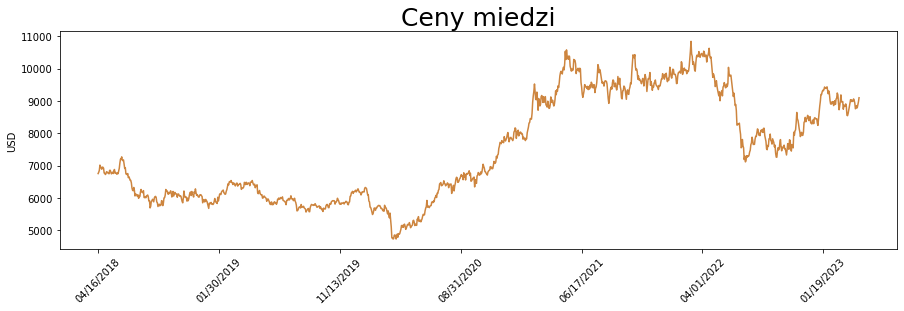

In [12]:
draw_stock(copper, 'peru', 'Ceny miedzi')

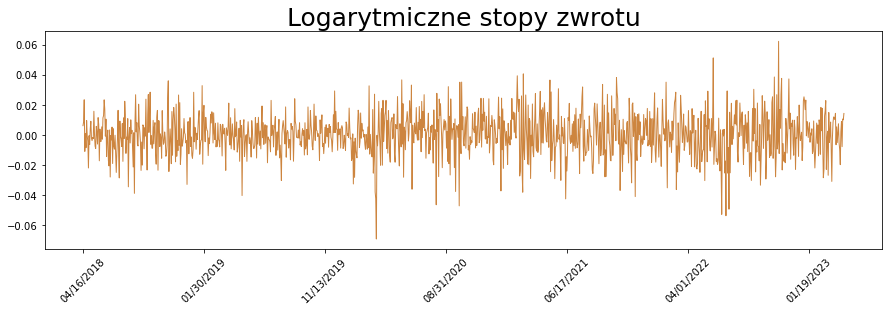

In [13]:
s_copper = np.array(copper['Open'].values)
r_copper = np.log(s_copper[1:]/s_copper[:-1]) #tu są logarytmiczne stopy zwrotu
t_copper = np.array([*range(len(r_copper))])
draw_ret(copper, 'peru', 'Logarytmiczne stopy zwrotu')

## Metoda parametryczna

In [6]:
from scipy.stats import logistic

In [7]:
mi = np.mean(r_copper)
sigma = stdev(r_copper)
p = [.95,.99]
lgstc = logistic.ppf(p, mi, math.sqrt(3)/math.pi*sigma)

In [8]:
lgstc

array([0.02291373, 0.0358921 ])

## Metoda historyczna - zwykła

In [9]:
from statsmodels.distributions.empirical_distribution import ECDF
import pandas as pd


In [10]:
distr_copper = ECDF(r_copper)

In [11]:
VaR_95 = np.quantile(r_copper,.95)
VaR_99 = np.quantile(r_copper,.99)
print(VaR_95,VaR_99)

0.02347116338449104 0.037608719620069585


In [12]:
new = sorted(r_copper)
new[-20:-1]

[0.034383730890892694,
 0.035060365329832414,
 0.03598191610437585,
 0.036217098442325554,
 0.03679416767819919,
 0.03710514617975447,
 0.037502320728765505,
 0.0377556514223466,
 0.03796982166926521,
 0.03872921384712447,
 0.040177318447642676,
 0.0408684726406883,
 0.04225385627110658,
 0.0423773121323162,
 0.04629157474298002,
 0.047009588531809005,
 0.0492135496536345,
 0.05266769997342544,
 0.0535525235669869]

In [13]:
# Example dataset
data = np.array([10, 20, 30, 40, 50])

# Computing the 25th and 75th percentiles
quantile_25 = np.quantile(data, 0.6)
quantile_75 = np.quantile(data, 0.75)

print(quantile_25)  # 25th percentile
print(quantile_75)  # 75th percentile

34.0
40.0


## Metoda historyczna - ważona

In [14]:
lambda_weight = .99

In [15]:
lambda_s = [lambda_weight**i for i in range(1,len(r_copper))]
ws = np.zeros((len(r_copper)))
ws[0] = 1/(1+sum(lambda_s))
ws[1:] = [ws[0]*lambda_weight**i for i in range(1,len(r_copper))]

In [16]:
ws = np.transpose(ws)
L = np.transpose(r_copper)

In [17]:
aaaa = np.array([r_copper,ws])
aaaa = np.transpose(aaaa)

In [18]:
aaaa

array([[-1.42711454e-02,  1.00000320e-02],
       [-1.00007007e-02,  9.90003165e-03],
       [-1.06032304e-02,  9.80103133e-03],
       ...,
       [-2.33584943e-02,  3.29462358e-08],
       [-8.55741074e-03,  3.26167735e-08],
       [-6.18089151e-03,  3.22906057e-08]])

In [19]:
hist_weight = pd.DataFrame(aaaa,columns=['L','w'])


In [20]:
hist_weight = hist_weight.sort_values(by=['L'])
hist_weight = hist_weight.reset_index(drop=True)


In [21]:
hist_weight['w_s'] = np.zeros(len(r_copper))
hist_weight

,L,w,w_s
0,-0.062109,0.003378,0.0
1,-0.051120,0.001141,0.0
2,-0.040523,0.000049,0.0
3,-0.039250,0.000044,0.0
4,-0.038452,0.003148,0.0
...,...,...,...
1254,0.047010,0.000017,0.0
1255,0.049214,0.001481,0.0
1256,0.052668,0.001313,0.0
1257,0.053553,0.001409,0.0


In [22]:

for i in range(0,len(r_copper)):
    hist_weight['w_s'][i] = sum(hist_weight['w'][:i+1])

In [23]:
hist_weight['w_s']

0       0.003378
1       0.004518
2       0.004567
3       0.004611
4       0.007759
          ...   
1254    0.995792
1255    0.997274
1256    0.998587
1257    0.999996
1258    1.000000
Name: w_s, Length: 1259, dtype: float64

In [24]:
ws_min_95 = min(abs(hist_weight['w_s']-0.95))
ws_min_99 = min(abs(hist_weight['w_s']-0.99))
print(ws_min_99)

0.001052704623480838


In [25]:
hist_weight[hist_weight['w_s'] == ws_min_95+.95]

,L,w,w_s
1204,0.024475,0.002305,0.950033


In [26]:
hist_weight_95 = hist_weight.iloc[(hist_weight['w_s']-.99).abs().argsort()[:1]][['L']]
hist_weight_95

,L
1234,0.030807


In [27]:
hist_weight_99 = float(hist_weight.iloc[(hist_weight['w_s']-.99).abs().argsort()[:1]]['L'])
hist_weight_99 #ja pierdole, oby tak miało być xd

0.030806771642757462

In [28]:
def hist_weight_fun(lam,ps,x):
    n = len(x)
    lambda_s = [lam**i for i in range(1,n)]
    
    ws = np.zeros((n))
    ws[0] = 1/(1+sum(lambda_s))
    ws[1:] = [ws[0]*lambda_weight**i for i in range(1,n)]

    m = np.array([x,ws])
    mt = np.transpose(m)
    hist_weight = pd.DataFrame(mt,columns=['L','w'])
    hist_weight = hist_weight.sort_values(by=['L'])
    hist_weight = hist_weight.reset_index(drop=True)

    hist_weight['w_s'] = np.zeros(n)
    for i in range(0,n):
        hist_weight['w_s'][i] = sum(hist_weight['w'][:i+1])

    result = [float(hist_weight.iloc[(hist_weight['w_s']-p).abs().argsort()[:1]]['L']) for p in ps]
    return(result)


In [29]:
hist_weight_fun(.99,[.95,.99],r_copper)

[0.024475034714765666, 0.030806771642757462]

## ARMA

In [42]:
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels as sm
import warnings
import os
from itertools import product
from datetime import datetime
from dateutil.parser import parse
warnings.filterwarnings('ignore')

In [43]:
import statsmodels as sm
model = sm.tsa.arima.model.ARIMA(r_copper, order = (1, 0, 0))
print(model)

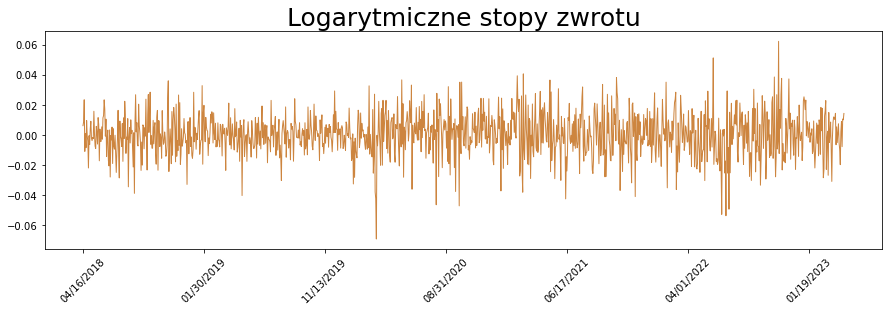

In [15]:
s_copper = np.array(copper['Open'].values)
r_copper = np.log(s_copper[1:]/s_copper[:-1]) #tu są logarytmiczne stopy zwrotu
t_copper = np.array([*range(len(r_copper))])
draw_ret(copper, 'peru', 'Logarytmiczne stopy zwrotu')

In [16]:
print('Średnia szeregu: ' + str(np.mean(r_copper)))

Średnia szeregu: -0.0002367193970863344


In [22]:
# Initial approximation of parameters
qs = range(0, 2)
ps = range(0, 2)
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.arima.model.ARIMA(r_copper, order=(param[0], 0, param[1])).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

AttributeError: module 'statsmodels' has no attribute 'tsa'

In [228]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1259
Model:                          ARIMA   Log Likelihood                3565.103
Date:                Mon, 12 Jun 2023   AIC                          -7126.206
Time:                        22:40:39   BIC                          -7115.930
Sample:                             0   HQIC                         -7122.344
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.599      0.549      -0.001       0.001
sigma2         0.0002   6.44e-06     31.519      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                79.96
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [229]:
results

[[(0, 0), -7126.20625170177],
 [(0, 1), -7124.462527000141],
 [(0, 2), -7122.564305537811],
 [(0, 3), -7120.609869516819],
 [(0, 4), -7118.866590341362],
 [(0, 5), -7116.884419965101],
 [(0, 6), -7117.583767695243],
 [(0, 7), -7117.660436695654],
 [(1, 0), -7124.459082110085],
 [(1, 1), -7122.416273430776],
 [(1, 2), -7120.526437153103],
 [(1, 3), -7118.446642544324],
 [(1, 4), -7116.803111109473],
 [(1, 5), -7114.903835919336],
 [(1, 6), -7115.471024930857],
 [(1, 7), -7115.772617947294],
 [(2, 0), -7122.562985865401],
 [(2, 1), -7120.317580082111],
 [(2, 2), -7118.206344596453],
 [(2, 3), -7120.493387988945],
 [(2, 4), -7115.918489865392],
 [(2, 5), -7114.391150968781],
 [(2, 6), -7114.443293045506],
 [(2, 7), -7113.763599867282],
 [(3, 0), -7120.620488358691],
 [(3, 1), -7118.618210026966],
 [(3, 2), -7116.206482511033],
 [(3, 3), -7118.336933870556],
 [(3, 4), -7114.765155141653],
 [(3, 5), -7112.54632510976],
 [(3, 6), -7115.18374292002],
 [(3, 7), -7114.987086577803],
 [(4, 0), -

In [50]:
import statsmodels

In [51]:
best_model = statsmodels.tsa.arima.model.ARIMA(r_copper, order=(1, 0, 0)).fit()

In [55]:
type(best_model)

statsmodels.tsa.arima.model.ARIMAResultsWrapper

In [52]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1259
Model:                 ARIMA(1, 0, 0)   Log Likelihood                3565.230
Date:                Mon, 12 Jun 2023   AIC                          -7124.459
Time:                        23:12:02   BIC                          -7109.045
Sample:                             0   HQIC                         -7118.666
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -0.594      0.552      -0.001       0.001
ar.L1         -0.0142      0.024     -0.585      0.558      -0.062       0.033
sigma2         0.0002    6.5e-06     31.268      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                78.64
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
preds = [best_model.simulate(nsimulations = 30) for i in range(10000)]
preds

[array([-0.01854498,  0.00909305, -0.01929565, -0.00478229, -0.02043368,
         0.0104157 ,  0.01896476,  0.00192184,  0.01895197, -0.01803283,
         0.02149713, -0.00518259, -0.00381254,  0.00032833,  0.0156898 ,
        -0.00107013,  0.01256358, -0.00587418,  0.02772551,  0.0127584 ,
         0.00127991,  0.03476859,  0.02679814,  0.04141291, -0.01411456,
        -0.00193395, -0.01243262,  0.00485515, -0.00042699,  0.00077592]),
 array([-0.01073457,  0.02722124, -0.00626776, -0.00502225, -0.0133152 ,
        -0.00470123,  0.01991601,  0.01312444,  0.02967262,  0.00644457,
        -0.0213339 ,  0.01742316,  0.0085382 ,  0.02149671, -0.00853013,
         0.01606322, -0.01633186,  0.00604101, -0.00694728,  0.02932697,
        -0.00130889, -0.02688605, -0.00677455,  0.02123357, -0.00698168,
        -0.00835361,  0.00715909,  0.0073737 ,  0.02526159,  0.00434671]),
 array([ 0.00459695, -0.01812787, -0.01018276,  0.00714829, -0.00575593,
         0.00359059, -0.00752008,  0.00120726, 

In [233]:
preds_day1 = [pred[0] for pred in preds]
preds_day30 = [pred[29] for pred in preds]

## Value at risk - day 1

In [24]:
plt.hist(preds_day1)
plt.show()

NameError: name 'preds_day1' is not defined

In [235]:
var95_day1 = np.quantile(preds_day1, .95)
var95_day1

0.02347107779387163

In [236]:
var99_day1 = np.quantile(preds_day1, .99)
var99_day1

0.03309460645518716

## Value at risk - day 30

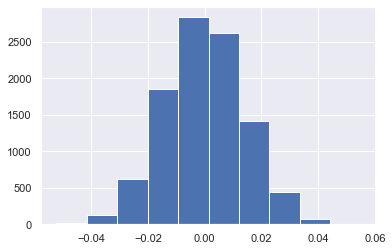

In [237]:
plt.hist(preds_day30)
plt.show()

In [238]:
var95_day1 = np.quantile(preds_day1, .95)
var95_day1

0.02347107779387163

In [239]:
var99_day30 = np.quantile(preds_day30, .95)
var99_day30

0.02298909609142762

In [49]:
X = r_copper
X

array([-0.01427115, -0.0100007 , -0.01060323, ..., -0.02335849,
       -0.00855741, -0.00618089])

## Backtesting - ARMA method

In [140]:
model = sm.tsa.arima.model.ARIMA(X, order=(1, 0, 0)).fit()
model.simulate(nsimulations = 30)

array([ 0.00055027, -0.00316143, -0.01773196, -0.01214007, -0.00944559,
       -0.00150019,  0.00857273, -0.00611483, -0.01339827, -0.02672086,
        0.00130326, -0.01639071, -0.00484637, -0.00873052, -0.00976988,
        0.00151309,  0.01079372, -0.00983726,  0.01384838,  0.01643322,
       -0.00280894, -0.00280095, -0.01567039,  0.00935748, -0.01837407,
        0.01812371, -0.0093098 , -0.00559481, -0.00858566, -0.05402403])

In [173]:
def backtesting_arma(n, alpha):
    I_1 = 0
    I_30 = 0
    for i in range(len(X) - n - 30):
        model = sm.tsa.arima.model.ARIMA(X[i:i+n], order=(1, 0, 0))
        results = model.fit()
        preds = [results.simulate(nsimulations=30) for i in range(1000)]
        pred_day1 = [pred[0] for pred in preds]
        pred_day30 = [pred[29] for pred in preds]
        I_1 += np.quantile(pred_day1, alpha) > X[i+n]
        I_30 += np.quantile(pred_day30, alpha) > X[i+n+29]
    return [np.mean(I_1), np.mean(I_30)]

In [219]:
alphas = np.linspace(0, 1, 100)
qs_day1 = []
qs_day30 = []
for alpha in alphas:
    q = backtesting_arma(100, alpha)
    q_day1 = q[0]
    q_day30 = q[1]
    qs_day1.append(q_day1)
    qs_day30.append(q_day30)

plt.figure(figsize=(10, 6))
plt.plot(alphas, qs_day1)
plt.plot(alphas, alphas)
plt.show()

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, qs_day30)
plt.plot(alphas, alphas)
plt.show()

In [174]:
q = backtesting_arma(100, .95)
q_day1 = q[0]
q_day30 = q[1]
qs_day1.append(q_day1)
qs_day30.append(q_day30)

KeyboardInterrupt: 

In [169]:
n = 100
i = 2
I_1, I_30 = 0, 0
alpha = .96
model = sm.tsa.arima.model.ARIMA(X[i:i+n+1], order=(1, 0, 0))
results = model.fit()
preds = [results.simulate(nsimulations=30) for i in range(1000)]
pred_day1 = [pred[0] for pred in preds]
pred_day30 = [pred[29] for pred in preds]
I_1 += np.quantile(pred_day1, alpha) > X[i+n+1]
I_30 += np.quantile(pred_day30, alpha) > X[i+n+30 - 1]

In [171]:
I_30

1